- Yahoo Finance 에서 주가 데이터 다운로드 (https://finance.yahoo.com/)
- 검색 후 Historical Data 선택
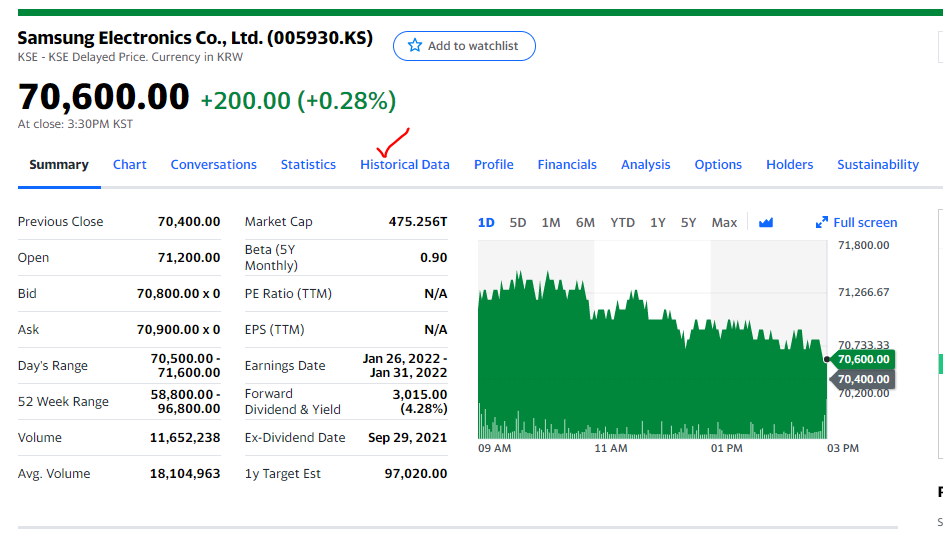

- 기간 선택 후 Apply -> Download 클릭
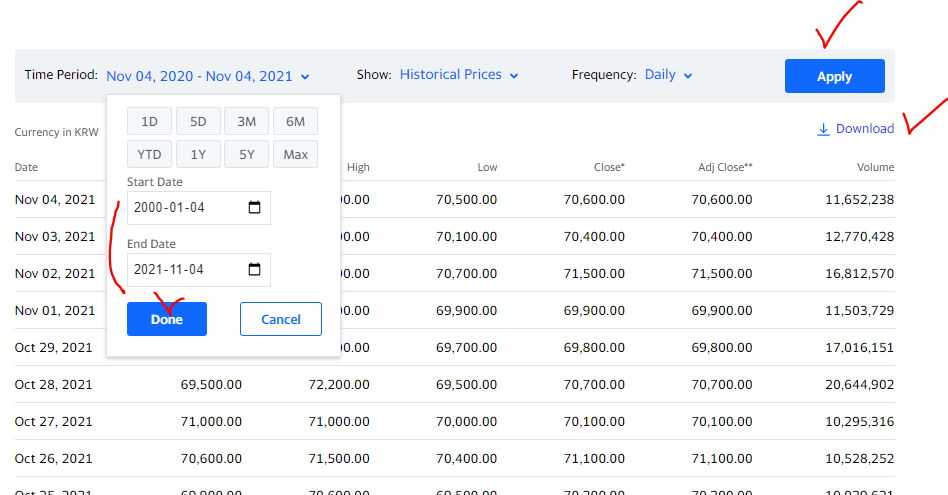

##### Data Loading 및 확인

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('005930.KS.csv')
df.shape

(6048, 7)

In [4]:
#Date 컬럼을 Datetime 타입으로 변환 후 index로 변환
df['Date'] = pd.to_datetime(df['Date'])  
df.set_index('Date', inplace=True)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4469.931152,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4082.198975,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4111.459473,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4052.932373,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4221.193848,46880000


<Axes: xlabel='Date'>

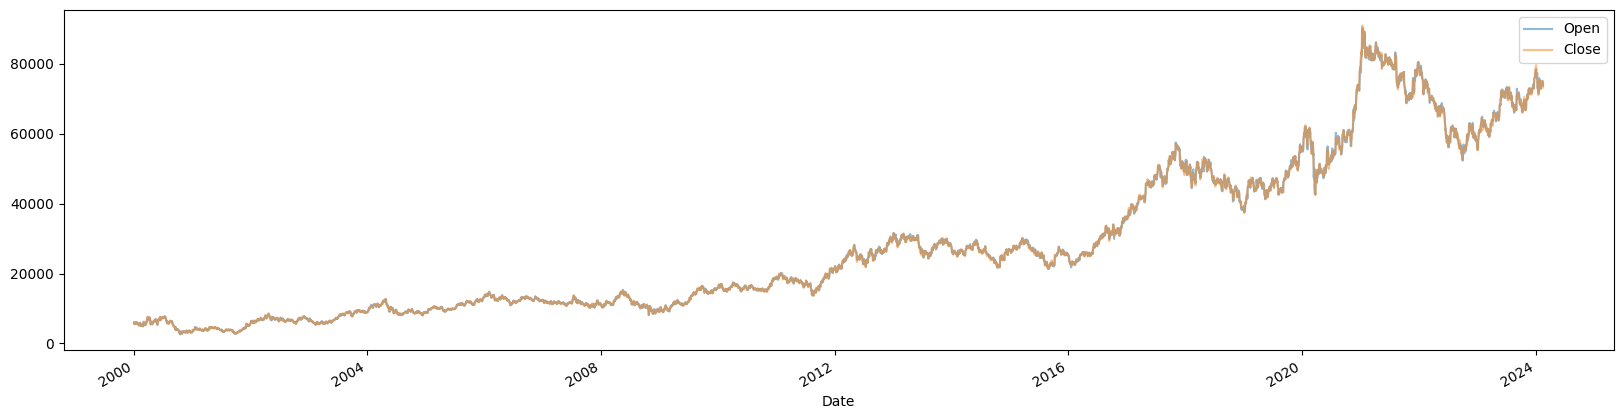

In [6]:
df[['Open', 'Close']].plot(figsize=(20,5), alpha=0.5)

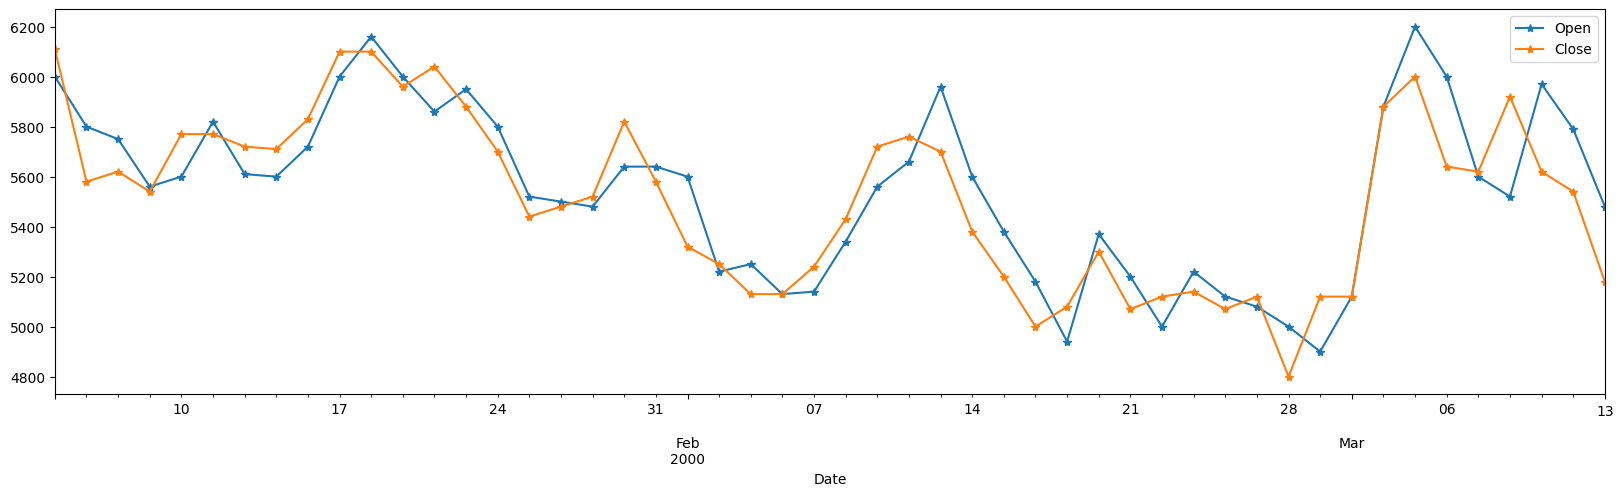

In [7]:
df[['Open', 'Close']].iloc[:50].plot(figsize=(20, 5), marker='*');

##### 전처리
- date를 index
- 결측치 제거
- Adj Close 컬럼 제거
- MinMaxScaling

In [8]:
df.drop(columns=['Adj Close'], inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,46880000


### X, y 분리

In [10]:
df_y = df['Close'].to_frame()
df_x = df

### Scaling - MinMaxScaler
- Scaler를 X, y 용 따로 만든다.
    - y를 inverse 하기 위해

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_scaler = MinMaxScaler()
X = scaler.fit_transform(df_x)
y = y_scaler.fit_transform(df_y)

##  날짜 종가 예측
- X: 50일치 주가(ex:1일 ~ 50일), y: 51일째 주가. (ex: 51일)
    - 50일의 연속된 주식가격을 할습하여 51일째 주가를 예측한다.
    - X의 한개의 데이터가 50일치 주가가 된다.
<br>

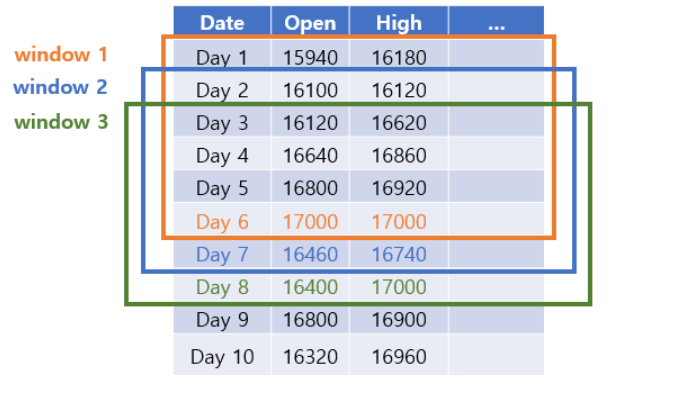
<center>[연속된 날짜가 5인 경우]</center>

X, y를 만든다.
각 index에 window size의 데이터셋이 들어가도록 한다.

##### input sequence dataset 만들기

In [12]:
window_size = 50  # 몇일 치를 한 단위로 묶을지 설정(50일치)
data_x = [] # input data들을 저장할 리스트
data_y = [] # output data를 저장할 리스트

for i in range(0, y.size - window_size):
    _X = X[i:i+window_size]
    _y = y[i+window_size]  
    data_x.append(_X)
    data_y.append(_y)

In [22]:
np.shape(data_x), np.shape(data_y)

((5998, 50, 5), (5998, 1))

## Train, Test 분리
- Train : 8, Test: 2의 비율로 나눈다.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [14]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

type(X_train)

numpy.ndarray

##### import

In [15]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

##### 하이퍼파라미터 정의

In [16]:
LEARNING_RATE = 0.001
N_EPOCH = 100
N_BATCH = 1000

## Model 생성

- LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 각 시퀀스에서 출력을 할 수 있다. 
    - return_sequences=True: 시퀀스마다 결과를 출력. False(기본값): 전체 Sequence를 처리하고 결과를 하나만 출력
- many to many 문제를 풀거나 LSTM 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 옵션을 사용. 
- Fully Connected Layer(Dense)와 연결된 경우 return_sequence=False로 해서 하나만 전달.
- 아래 그림에서 왼쪽은 return_sequences=False일 때, 오른쪽은 return_sequence=True일 때의 형상.

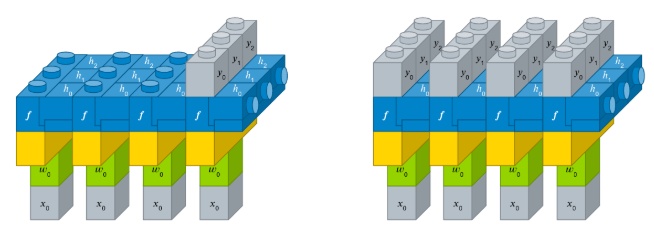

<center>[출처: https://tykimos.github.io/2017/04/09/RNN_Getting_Started]</center>

##### 모델 생성, 컴파일

In [24]:
X_train.shape

(4798, 50, 5)

In [27]:
def get_model():
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(window_size, 5)))
    model.add(layers.LSTM(32, return_sequences=False, activation='tanh'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')
    
    return model

In [28]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5953 (23.25 KB)
Trainable params: 5953 (23.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### 모델 학습, 평가

In [30]:
hist = model.fit(X_train, y_train, 
                 epochs=N_EPOCH, 
                 validation_split=0.2)

Epoch 1/100
120/120 [==============================] - 2s 19ms/step - loss: 1.7149e-04 - val_loss: 1.3798e-04
Epoch 2/100
120/120 [==============================] - 2s 16ms/step - loss: 1.2477e-04 - val_loss: 1.3752e-04
Epoch 3/100
120/120 [==============================] - 2s 17ms/step - loss: 1.2624e-04 - val_loss: 1.7508e-04
Epoch 4/100
120/120 [==============================] - 2s 17ms/step - loss: 1.1096e-04 - val_loss: 1.1630e-04
Epoch 5/100
120/120 [==============================] - 2s 19ms/step - loss: 1.0213e-04 - val_loss: 1.1050e-04
Epoch 6/100
120/120 [==============================] - 2s 17ms/step - loss: 9.4146e-05 - val_loss: 1.0245e-04
Epoch 7/100
120/120 [==============================] - 2s 17ms/step - loss: 1.1553e-04 - val_loss: 1.1277e-04
Epoch 8/100
120/120 [==============================] - 2s 17ms/step - loss: 9.3797e-05 - val_loss: 1.6496e-04
Epoch 9/100
120/120 [==============================] - 2s 17ms/step - loss: 1.1627e-04 - val_loss: 1.0566e-04
Epoch 10/1

##### 결과 시각화

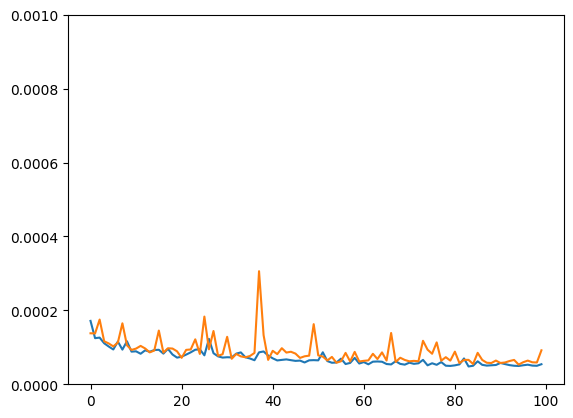

In [31]:
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss']);
plt.ylim(0,0.001)
plt.show()

##### 최종평가

In [32]:
model.evaluate(X_test, y_test)

38/38 [==============================] - 1s 6ms/step - loss: 8.4805e-05


8.480528049403802e-05

##### 다음날 주가 예측
- 마지막 50일치로 내일 주가를 예측해 본다.

In [33]:
new_data = X[-50:][np.newaxis, ...]
new_data.shape

(1, 50, 5)

In [34]:
pred = model.predict(new_data)

1/1 [==============================] - 0s 427ms/step


In [35]:
pred

array([[0.7837259]], dtype=float32)

In [36]:
y_scaler.inverse_transform(pred)

array([[71909.484]], dtype=float32)